Import modules into memory

In [1]:
import pandas as pd
import numpy as np
import math
import os
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import operator
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy import stats

# The below suppresses all warnings in the notebook
# Only leave this uncommented for display purposes
import warnings
warnings.filterwarnings("ignore")

In [2]:
# These are predefined as global parameters, and will be used for optimizing the Learning Curve for
# comparing between different orders of polynomial regression
global lambd_1st_order,lambd_2nd_order,lambd_3rd_order,lambd_4th_order,lambd_5th_order
global learning_rate_1st_order,learning_rate_2nd_order,learning_rate_3rd_order,learning_rate_4th_order,learning_rate_5th_order
global regularizer_1st_order,regularizer_2nd_order,regularizer_3rd_order,regularizer_4th_order,regularizer_5th_order

Uses dynamic programming to recursively calculate all possible ways we can multiply columns together by considering column indices

In [3]:
def allNumberRecur (vector, data, last, index): 
    length = len(vector)
    
    # One by one fix all characters at the given index and 
    # recur for the subsequent indexes 
    for i in range(length): # For same i we go through all possible indexes
        
        # Fix the ith character at index and if this is not 
        # the last index then recursively call for higher 
        # indexes 
        data[index] = vector[i] 
  
        # If this is the last index then print the string 
        # stored in data[] 
        if index==last:
            my_list.append(sorted(data[:]))
            
        else: 
            allNumberRecur(vector, data, last, index+1) 

In [4]:
def allNum(vector,degree): 
    length = len(vector) 
    
    # Create a temp array that will be used by
    data = [""]*(degree)
    
    # Now print all permutaions 
    my_list=allNumberRecur(vector, data, degree-1, 0)  

This is the main function which calls the two above and is used to expand our feature set

In [5]:
def polynomialFeatures(X, degree):
    # Strip off bias column from X
    X=np.delete(X, [0], axis=1)
    
    #assign default value to degree is there is none
    degree = 1 if degree is None else degree
    temp={}#append each order to a dictionary
    vector_of_index=np.arange(X.shape[1])#vector of indices to easily access entry
    if degree==1:
        X=X
    else:
        
        for polyd in range(1,degree+1):
            global my_list
            my_list=[]
            allNum(vector_of_index,polyd) 
            #drop identical entries from the list
            if polyd>=2:
                # Removes duplicate multiplications from consideration, as order does not matter
                b_set = set(tuple(x) for x in my_list)
                b = [ list(x) for x in b_set ]
                temp[polyd]=b
            else:
                temp[polyd]=my_list
        #now multiply all elements in columns in this order
        for polyd in range(2,degree+1):
            temp_list=np.asarray(temp[polyd])
            for i in range(temp_list.shape[0]):
                cols=list(temp_list[i][:])            
                extracted_columns=np.prod(X[:,cols],axis=1).reshape(-1,1)
                #now append this to original matrix
                X=np.hstack([X,extracted_columns])
    
    # Rescale this new feature matrix before returning
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)
    # Before returning add back the bias column to X
    X = np.c_[np.ones((X.shape[0],1)),X]
    return X

Calculates MSE between predicted values and true values

In [6]:
def mse(Y_true, Y_pred):
    cost = np.mean((Y_pred - Y_true) ** 2)
    return cost

Calculates MSE with L1 regularization

In [7]:
def mse_l1(Y_true, Y_pred,lamb,theta):
    # lamb is the regularization parameter
    # theta contains the weights
    
    # Note bias term excluded for regularized addition term
    theta_sum = sum([theta[index] for index in range(1,theta.shape[0])])
    cost = mse(Y_true,Y_pred) + lamb/(2*theta.shape[0])*theta_sum
    
    return cost

Calculates MSE with L2 regularization

In [8]:
def mse_l2(Y_true, Y_pred,lamb,theta):
    # lamb is the regularization parameter
    # theta contains the weights
    
    # Note bias term excluded for regularized addition term
    theta_sum_sqrd = sum([theta[index]**2 for index in range(1,theta.shape[0])])
    cost = mse(Y_true,Y_pred) + lamb/(2*theta.shape[0])*theta_sum_sqrd
    
    return cost

This definition creates a learning curve to find the optimal number of samples to include when training the model

In [9]:
def learning_curve(model, X, Y, cv, train_size=1, learning_rate=0.01, epochs=1000, tol='None', regularizer='None', lambd=0.0, **kwargs):
    # model : object type that implements the “fit” and “predict” methods. An object of that type
    # which is cloned for each validation.
    # Probably contains arguments fed into the Linear Regression Fit definition
    # The below are probably what is sent in
    # model_args = [learning_rate, epochs, tol, regularizer, lambd]
    
    # X : ndarray A numpy array with rows representing data samples and columns representing features.
    
    #  Y : ndarray A 1D numpy array with labels corresponding to each row of the feature matrix X.
    
    # cv : int integer, to specify the number of folds in a k-fold cross-validation.
    
    # train_sizes : int or float Relative or absolute numbers of training examples that will be used to
    # generate the learning curve. If the dtype is float, it is regarded as a
    # fraction of the maximum size of the training set (that is determined by
    # the selected validation method), i.e. it has to be within (0, 1]. Otherwise
    # it is interpreted as absolute sizes of the training sets.
    
    # learning_rate : float It provides the step size for parameter update.
    
    # epochs : int The maximum number of passes over the training data for updating the weight vector.
    
    # tol : float or None The stopping criterion. If it is not None, the iterations will stop when
    # (error > previous_error - tol). If it is None, the number of iterations will
    # be set by the “epochs”.
    
    # regularizer : string
    # The string value could be one of the following: l1, l2, None.
    # If it’s set to None, the cost function without the regularization term will
    # be used for computing the gradient and updating the weight vector.
    # However, if it’s set to l1 or l2, the appropriate regularized cost function
    # needs to be used for computing the gradient and updating the weight
    # vector.
    
    # lambd : float
    # It provides the regularization coefficient. It is used only when the
    # “regularizer” is set to l1 or l2.
    
    num_folds = cv
    error_function = mse
    
    num_rows = X.shape[0]
    train_scores=[]
    val_scores=[]
    
    # The below decides on the number of iterations to perform, rounding down to not include extra at end
    # Note we cut off the remaining iterations
    if type(train_size)==int:
        num_in_train_set = train_size
    else:
        num_in_train_set = num_rows * train_size
        
    num_iterations = math.floor(num_rows / num_in_train_set)
    for i in range(0,num_iterations):
        print('Including up to bin %i out of %i' %(i+1,num_iterations))
        model_name = Linear_Regression()
        model = [model_name.fit,model_name.predict]
        model_args = [epochs,tol,lambd_curr,learning_rate_curr,regularizer_curr]
        dict_temp={}
        curr_rows = list(range(0,(i+1)*num_in_train_set))
        curr_X = X[curr_rows,:] # Grab selected row range in X
        curr_Y = Y[curr_rows,:] # Grab selected row range in Y
        # For this perform S-fold cross-validation
        dict_temp=kFold(cv, curr_X, curr_Y, model, model_args, error_function)
        values=np.array([dict_temp[keys][-1] for keys in dict_temp])#list of lists for each iteration
        #take average of first column to give train avg,second for test_avg
        train_scores.append(math.sqrt((values[:,0].sum())/num_folds))
        val_scores.append(math.sqrt((values[:,1].sum())/num_folds))
    
    return np.sqrt(train_scores), np.sqrt(val_scores)

This creates a learning curve for showing how the error changes for different polynomial orders

In [10]:
def plot_polynomial_model_complexity(model,X,Y,cv,maxPolynomialDegree,learning_rate=0.01, epochs=1000, tol='None', regularizer='None', lambd=0.0, **kwargs):

    degreeList = []
    train_scores = []
    val_scores = []
    for n in range(1,maxPolynomialDegree+1):
        
        print('Generating output for Polynomial Order %i out of %i' %(n,maxPolynomialDegree) )
        
        # If the user has defined global variables for a particular polynomial order we use those
        # Otherwise, use the provided parameter values for desired higher order terms
        if (n==1):
            learning_rate=learning_rate_1st_order
            regularizer=regularizer_1st_order
        if (n==2):
            lambd=lambd_2nd_order
            learning_rate=learning_rate_2nd_order
            regularizer=regularizer_2nd_order
        if (n==3):
            lambd=lambd_3rd_order
            learning_rate=learning_rate_3rd_order
            regularizer=regularizer_3rd_order
        if (n==4):
            lambd=lambd_4th_order
            learning_rate=learning_rate_4th_order
            regularizer=regularizer_4th_order
        if (n==5):
            lambd=lambd_5th_order
            learning_rate=learning_rate_5th_order
            regularizer=regularizer_5th_order
        
        X_aug=polynomialFeatures(X,n)
        model_args = [epochs,tol,lambd_curr,learning_rate_curr,regularizer_curr]
        dict_items=kFold(cv, X_aug, Y, model, model_args, error_function)
        values=np.array([dict_items[keys][-1] for keys in dict_items])#list of lists for each iteration
        
        #take average of first column to give train avg,second for test_avg
        train_scores.append(math.sqrt((values[:,0].sum())/cv))
        val_scores.append(math.sqrt((values[:,1].sum())/cv))
        degreeList.append(n)

    # Below plots the “rmse vs. degree”
    plt.figure(figsize=(10, 6))   
    plt.plot(degreeList, train_scores, "ro-", alpha=1.0, linewidth=1.0, label="Test RMSE")
    plt.plot(degreeList, val_scores, "bo-", alpha=1.0, linewidth=1.0, label="Train RMSE")    
    plt.legend(loc="best", fontsize=14) 
    plt.xlabel("Degree")
    plt.ylabel("RMSE")
    plt.title("RMSE for Varying Degree")
    plt.show()

Creates the main Linear Regression Class

In [11]:
class Linear_Regression():
    
    def __init__(self):
        pass
    
    # This part performs Batch gradient descent
    def fit(self, X, Y, epochs=1000,tol='None',lambd=0.0,learning_rate=0.01,regularizer='None',  **kwargs):
        # the “fit” method should use a weight vector “theta_hat” that contains the
        # parameters for the model (one parameter for each feature and one for bias). The
        # “theta_hat” should be a 1D column vector.
        # Finally, it should update the model parameter “theta” to be used in “predict”
        # method as follows.
        # self.theta = theta_hat
        
        # We will implement batch gradient descent
        
        # X is a numpy array for features
        # Y is a 1D numpy array containing true labels for each row
        # learning_rate contains step size for updating the parameters
        # epochs is the maximum number of passes allowed
        
        # tol is The stopping criterion. If it is not None, the iterations will stop when
        # (error > previous_error - tol). If it is None, the number of iterations will
        # be set by the “epochs”.
        
        # regularizer is The string value could be one of the following: l1, l2, None.
        # If it’s set to None, the cost function without the regularization term will
        # be used for computing the gradient and updating the weight vector.
        # However, if it’s set to l1 or l2, the appropriate regularized cost function
        # needs to be used for computing the gradient and updating the weight
        # vector.
        
        # lambd is the regularization coefficient. It is used only when the “regularizer” is set to l1 or l2
        
        m = X.shape[0] # Number of elements in X
        n = X.shape[1] # Number of columns in X
        
        # Initialize theta as all zeros with correct dimensions
        self.theta = np.zeros(n).reshape((n, 1))
        
        if 'None' is tol:# This runs until number of iterations=epochs
            num_iterations = 0
            while num_iterations <= epochs: # Stop if we reach maximum number of iterations
                num_iterations+=1
                # Get predictions for target before updating the weights
                Y_pred = self.predict(X)
                diff_piece = Y_pred - Y
                # make sure matrix multiplication of below works correctly
                if 'None' in regularizer:
                    # This defines our update rule for theta_hat using unregularized approach
                    self.theta = self.theta - (learning_rate/m)*np.dot(X.T,diff_piece)
                    # Using new weights evaluate our new predictions
                    y_pred = self.predict(X)
                    # Now evaluate MSE for prediction
                    error = mse(Y, Y_pred)
                if ('l1' in regularizer):
                    self.theta = self.theta - (learning_rate/m)*np.dot(X.T,diff_piece) - (learning_rate*lambd/m)*np.sign(self.theta)
                    # Using new weights evaluate our new predictions
                    y_pred = self.predict(X)
                    # Now evaluate MSE for prediction
                    error = mse_l1(Y, Y_pred,lambd,self.theta)
                if ('l2' in regularizer):
                    self.theta = self.theta - (learning_rate/m)*np.dot(X.T,diff_piece) - (learning_rate*lambd/m)*self.theta
                    # Using new weights evaluate our new predictions
                    y_pred = self.predict(X)
                    # Now evaluate MSE for prediction
                    error = mse_l2(Y, Y_pred,lambd,self.theta)
                
        else: # Stops at max iterations or when error not decreasing significantly
            num_iterations = 0
            while num_iterations <= epochs: # Stop if we reach maximum number of iterations
                num_iterations+=1
                # Get predictions for target before updating the weights
                Y_pred = self.predict(X)
                diff_piece = Y_pred - Y
                # make sure matrix multiplication of below works correctly
                if 'None' in regularizer:
                    # This defines our update rule for theta_hat using unregularized approach
                    self.theta = self.theta - (learning_rate/m)*np.dot(X.T,diff_piece)
                    # Using new weights evaluate our new predictions
                    y_pred = self.predict(X)
                    # Now evaluate MSE for prediction
                    error = mse(Y, Y_pred)
                if ('l1' in regularizer):
                    self.theta = self.theta - (learning_rate/m)*np.dot(X.T,diff_piece) - (learning_rate*lambd/m)*np.sign(self.theta)
                    # Using new weights evaluate our new predictions
                    y_pred = self.predict(X)
                    # Now evaluate MSE for prediction
                    error = mse_l1(Y, Y_pred,lambd,self.theta)
                if ('l2' in regularizer):
                    self.theta = self.theta - (learning_rate/m)*np.dot(X.T,diff_piece) - (learning_rate*lambd/m)*self.theta
                    # Using new weights evaluate our new predictions
                    y_pred = self.predict(X)
                    # Now evaluate MSE for prediction
                    error = mse_l2(Y, Y_pred,lambd,self.theta)
                    
                # Each time check to see if error not decreasing significantly before looping back through
                if (num_iterations > 1): # Can only check if not the first pass
                    if abs(error-previous_error) < tol:
                        break # Break out if we are not improving our error significantly
                previous_error = error
    
    # This part performs Stochastic gradient descent
    def fit_stochastic(self, X, Y, epochs=1000,tol='None',lambd=0.0,learning_rate=0.01,regularizer='None',  **kwargs):

        m = X.shape[0] # Number of elements in X
        n = X.shape[1] # Number of columns in X
        
        # Initialize theta as all zeros with correct dimensions
        self.theta = np.zeros(n).reshape((n, 1))
        
        
        if 'None' is tol:# This runs until number of iterations=epochs
            num_iterations = 0
            while num_iterations <= epochs: # Stop if we reach maximum number of iterations
                num_iterations+=1
                
                random_index=np.random.randint(0,m)
                X_i=X[random_index,:].reshape(1,X.shape[1])
                Y_i = Y[random_index].reshape(1,1)
                # Get predictions for target before updating the weights
                y_pred = np.dot(X_i,self.theta)
                
                diff_piece = y_pred - Y_i
                # make sure matrix multiplication of below works correctly
                if 'None' in regularizer:
                    # This defines our update rule for theta_hat using unregularized approach
                    self.theta = self.theta - (learning_rate/m)*np.dot(X_i.T,diff_piece)
                    # Using new weights evaluate our new predictions
                    y_pred = self.predict(X)
                    # Now evaluate MSE for prediction
                    error = mse(Y, y_pred)
                if ('l1' in regularizer):
                    self.theta = self.theta - (learning_rate/m)*np.dot(X_i.T,diff_piece) - (learning_rate*lambd/m)*np.sign(self.theta)
                    # Using new weights evaluate our new predictions
                    y_pred = self.predict(X)
                    # Now evaluate MSE for prediction
                    error = mse_l1(Y, y_pred,lambd,self.theta)
                if ('l2' in regularizer):
                    self.theta = self.theta - (learning_rate/m)*np.dot(X_i.T,diff_piece) - (learning_rate*lambd/m)*self.theta
                    # Using new weights evaluate our new predictions
                    y_pred = self.predict(X)
                    # Now evaluate MSE for prediction
                    error = mse_l2(Y, y_pred,lambd,self.theta)
                
        else: # Stops at max iterations or when error not decreasing significantly
            num_iterations = 0
            while num_iterations <= epochs: # Stop if we reach maximum number of iterations
                num_iterations+=1
                
                random_index=np.random.randint(0,m)
                X_i=X[random_index,:].reshape(1,X.shape[1])
                Y_i = Y[random_index].reshape(1,1)
                # Get predictions for target before updating the weights
                y_pred = self.predict(X)
                # Get predictions for target before updating the weights
                y_pred = np.dot(X_i,self.theta)
                
                diff_piece = y_pred - Y_i
                # make sure matrix multiplication of below works correctly
                if 'None' in regularizer:
                    # This defines our update rule for theta_hat using unregularized approach
                    self.theta = self.theta - (learning_rate/m)*np.dot(X_i.T,diff_piece)
                    # Using new weights evaluate our new predictions
                    y_pred = self.predict(X)
                    # Now evaluate MSE for prediction
                    error = mse(Y, y_pred)
                if ('l1' in regularizer):
                    self.theta = self.theta - (learning_rate/m)*np.dot(X_i.T,diff_piece) - (learning_rate*lambd/m)*np.sign(self.theta)
                    # Using new weights evaluate our new predictions
                    y_pred = self.predict(X)
                    # Now evaluate MSE for prediction
                    error = mse_l1(Y, y_pred,lambd,self.theta)
                if ('l2' in regularizer):
                    self.theta = self.theta - (learning_rate/m)*np.dot(X_i.T,diff_piece) - (learning_rate*lambd/m)*self.theta
                    # Using new weights evaluate our new predictions
                    y_pred = self.predict(X)
                    # Now evaluate MSE for prediction
                    error = mse_l2(Y, y_pred,lambd,self.theta)
                    
                # Each time check to see if error not decreasing significantly before looping back through
                if (num_iterations > 1): # Can only check if not the first pass
                    if abs(error-previous_error) < tol:
                        break # Break out if we are not improving our error significantly
                previous_error = error
    
    # Given the calculated weights this returns the predictions for the values
    def predict(self, X):
        # This definition uses the self.theta to make predictions
        # pred is a 1D array of predictions for each row in X, as a column vector
        preds = np.matmul(X,self.theta)
        return preds

Import the dataset into a pandas dataframe

In [12]:
# Read in data into pandas dataframe
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Get summary statistics for all features in the dataframe

In [13]:
# Display the statistical descriptions of all variables in this notebook
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


We now shuffle the rows are our dataframe to remmove any bias from the ordering

In [14]:
# Shuffle the rows to prevent the order in which data was entered to affect results
df = df.sample(frac=1)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
477,10.4,0.24,0.49,1.8,0.075,6.0,20.0,0.99770,3.18,1.06,11.0,6
522,8.2,0.39,0.49,2.3,0.099,47.0,133.0,0.99790,3.38,0.99,9.8,5
420,9.5,0.56,0.33,2.4,0.089,35.0,67.0,0.99720,3.28,0.73,11.8,7
265,11.8,0.26,0.52,1.8,0.071,6.0,10.0,0.99680,3.20,0.72,10.2,7
1030,7.1,0.59,0.00,2.1,0.091,9.0,14.0,0.99488,3.42,0.55,11.5,7


We now use seaborn to generate pair plots to assess the correlation and covariance between features in our dataframe

In [15]:
# Definition to calculate correlation coefficient, which will be used below for inclusion in the seaborn plots
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r), xy=(.1, .6), xycoords=ax.transAxes, size = 24)

In [16]:
# This is a definition to create the pairwise seaborn plots
def create_pairwise_plots(df):
    cmap = sns.cubehelix_palette(light=1, dark = 0.1, hue = 0.5, as_cmap=True)
    sns.set_context(font_scale=2)
    g = sns.PairGrid(df) # Set up pair grid
    g.map_upper(plt.scatter, s=10, color = 'red') # Set up scatter plot on the upper triangle
    g.map_diag(sns.distplot, kde=False, color = 'red') # Set up distribution on the diagonal
    g.map_lower(sns.kdeplot, cmap = cmap) # Include density Plot on the lower triangle
    g.map_lower(corrfunc); # Add correlation coefficients to density plots on the lower triangle

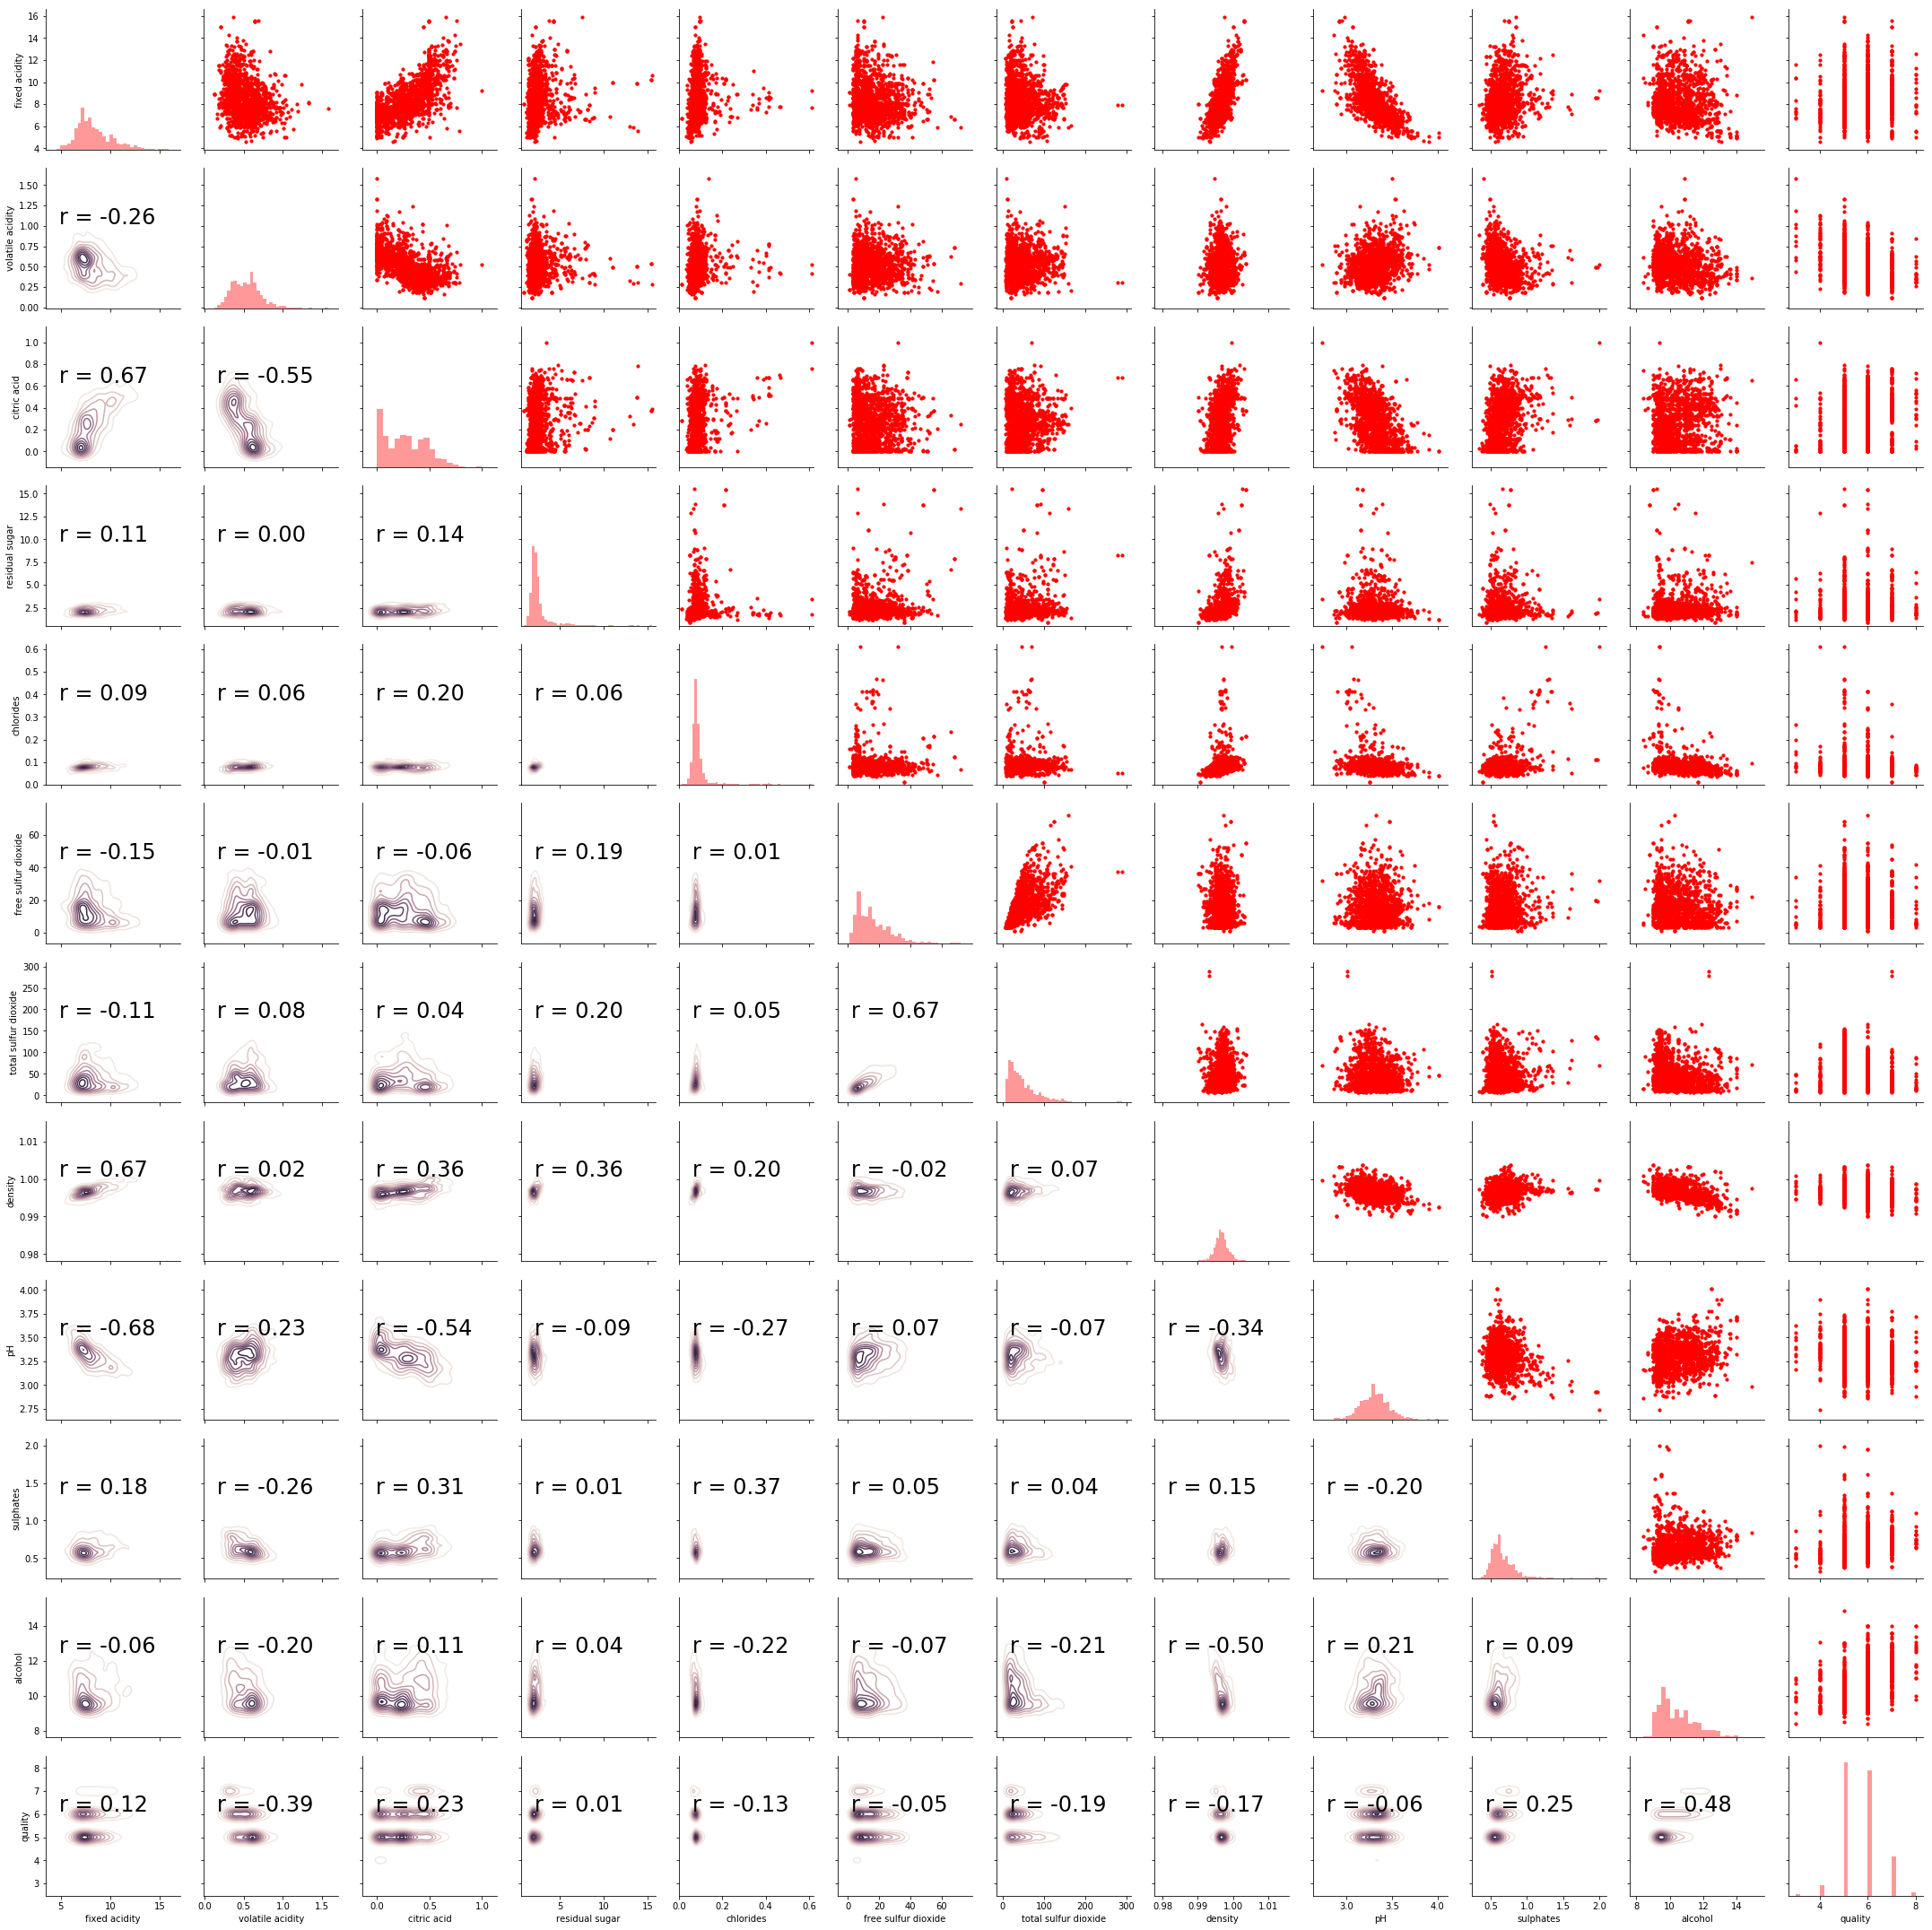

In [17]:
# Create pairwise plots
create_pairwise_plots(df)

From the above plots we see that none of the features have an extremely strong covariance or correlation, but that there are some which can probably be removed in order to simplify our model. With this is mind we will remove the features below:<br>

Citric Acid seems to covary significantly with fixed acidity, and also has a fairly large correlation. It also seems to be covarying with volatile acidity. We will citric acid from our model.<br>
Total Sulfur dioxide seems to covary with free sulfur dioxide. As neither seems to covary signifiantly with other features it is not clear which to remove, but we choose to remove free sulfur dioxide.<br>
Density and fixed acidity have a strong correlation. Fixed Acidity also has a strong association with pH. We will remove fixed acidity from our model.<br>

In [18]:
# Here we drop the noted covarying/correlated features
df = df.drop(columns=['citric acid','free sulfur dioxide','fixed acidity'])

We now reinvestigate the seaborn plots to ensure no redundant features still remain

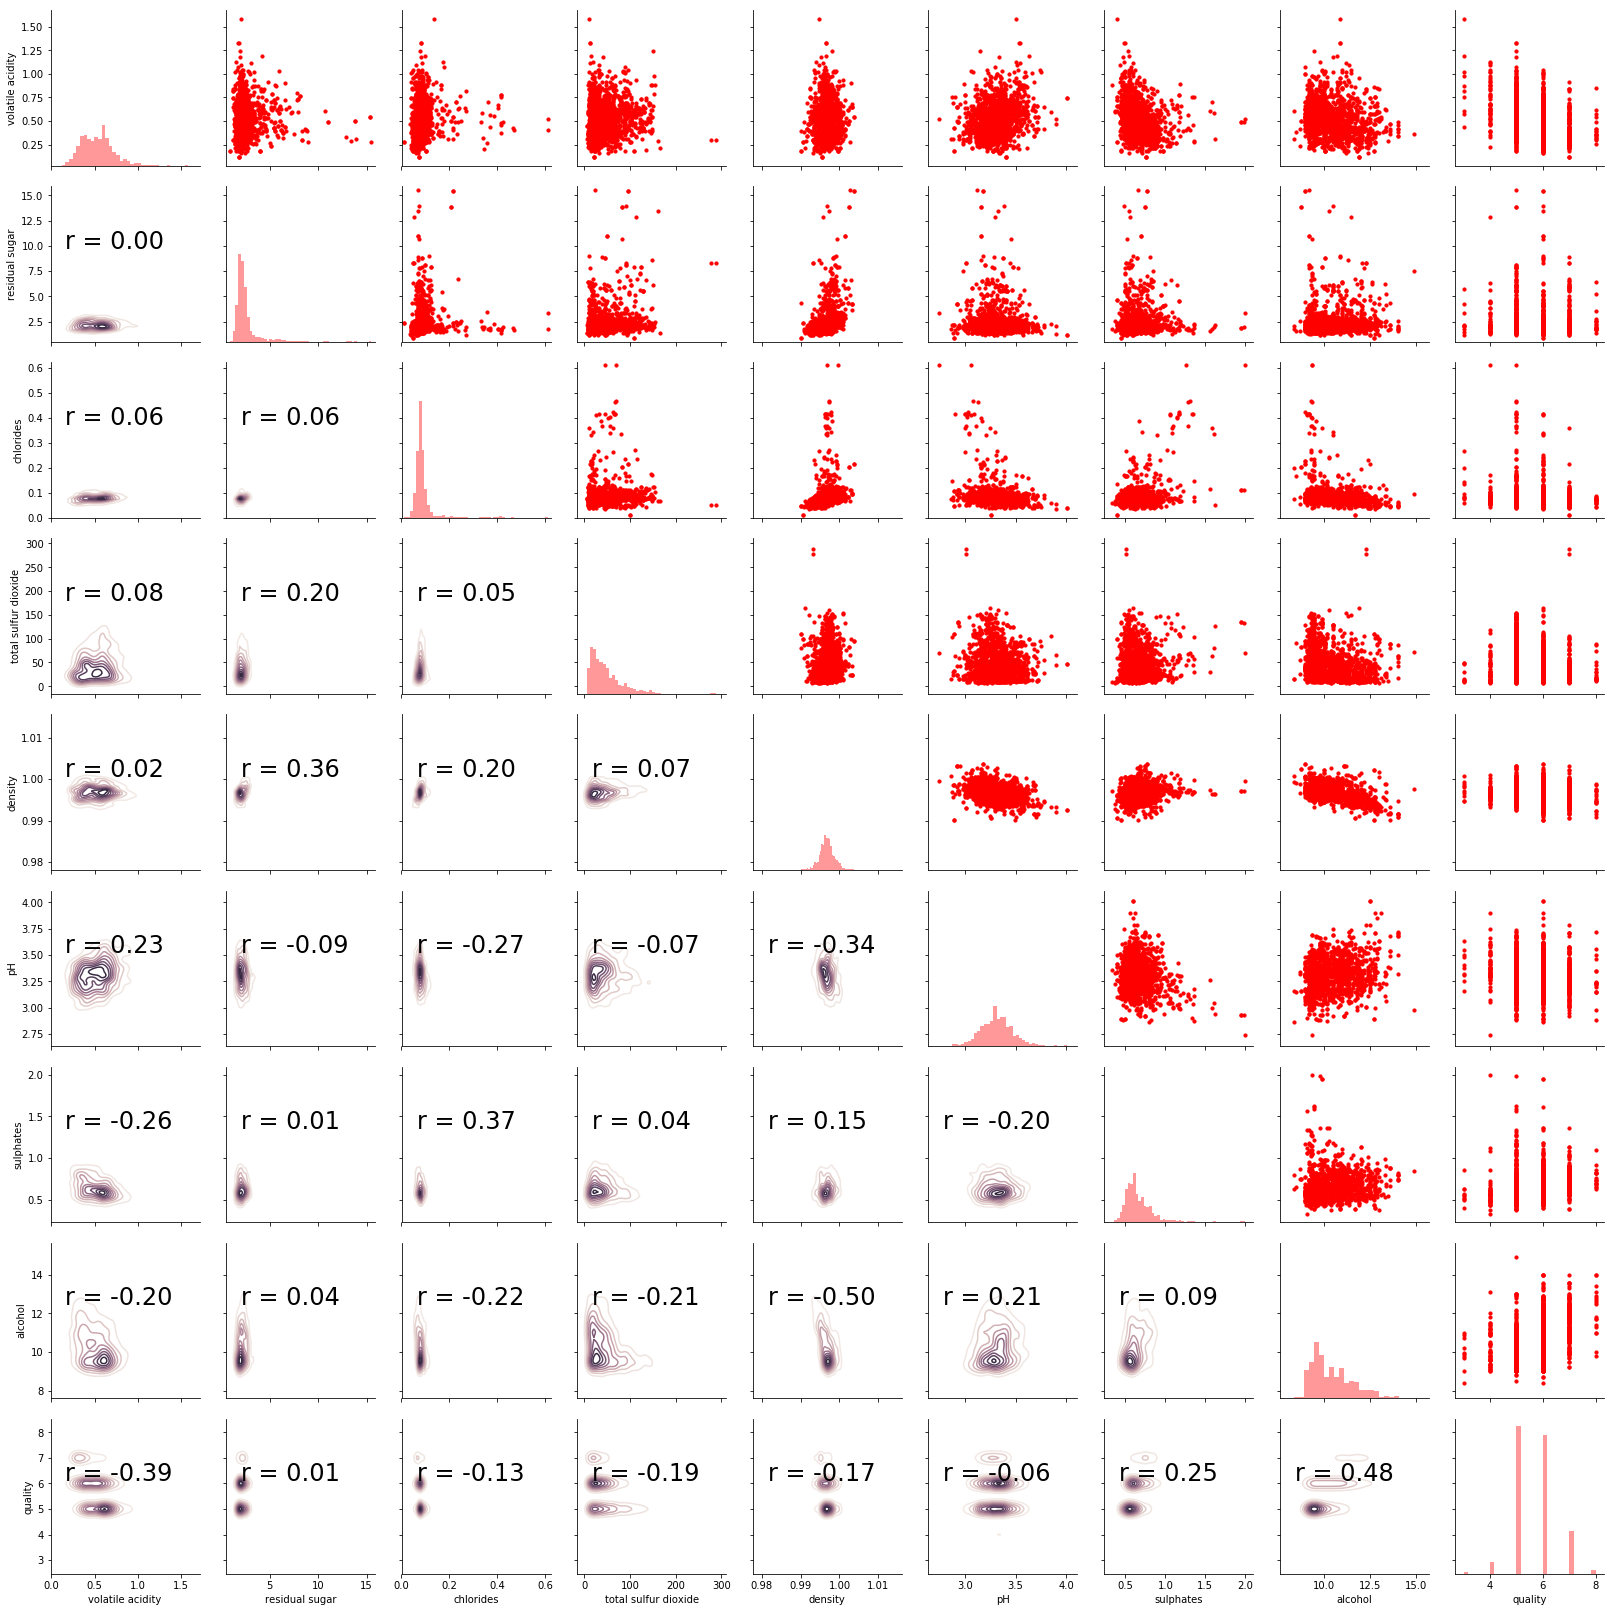

In [19]:
create_pairwise_plots(df)

This seems like a good set of features to include

The below is a definition which splits the data into testing and training sets for the chosen feature matrix and target column

In [20]:
# This box partitions data into training and testing sets
def partion(X,Y,t,random_state):
    np.random.seed(seed=random_state)
    num_rows = X.shape[0]
    test_size = int(t * num_rows)
    row_vec = list(range(0,num_rows))
    np.random.shuffle(row_vec) # randomize the ordering
    test_rows = row_vec[0 : test_size]
    
    train_rows = row_vec[test_size+1:len(row_vec)-1]
    
    # Now define x and y for training and testing
    X_test = X[test_rows,:]
    X_train = X[train_rows,:]
    Y_test = Y[test_rows]
    Y_train = Y[train_rows]
    return X_test,X_train,Y_test,Y_train

The below definition creates tupples holding the feature data and labels belonging to each fold of partitioned data<br>
It is called on by the k-fold cross-validation function.

In [21]:
def split_data_folds(folds,data,labels,random_state):
    np.random.seed(seed=random_state)
    num_rows=data.shape[0]
    row_vec = list(range(0,num_rows))
    np.random.shuffle(row_vec) # randomize the ordering
    data=data[row_vec,:]
    labels=labels[row_vec]
    fold_size=int(data.shape[0]/folds) # Number of rows in each set
    fold_list=[]
    for i in range(folds):
        data_fold=data[i*fold_size:(i+1)*fold_size,:]
        labels_fold=labels[i*fold_size:(i+1)*fold_size]
        fold_list.append((data_fold,labels_fold))
    return fold_list   

Below we have created a function to emply k-fold cross validation

In [22]:
def kFold(folds, data, labels, model, model_args, error_function):
    random_state=42
    dataset_split=split_data_folds(folds,data,labels,random_state)
    kwargs={}
    error_per_fold=[]
    preds_per_fold=[]
    dict_per_fold={}
    keys=[]

    for i in range(folds):
        X_split_test=dataset_split[i][0]
        Y_split_test=dataset_split[i][-1]
        X_split_train=dataset_split[~i][0]
        Y_split_train=dataset_split[~i][-1]
        
        fit_function=model[0]
        predict_function=model[1]
        
        fit_function(X_split_train,Y_split_train, *model_args,**kwargs)
        
        naive_train_predictions=predict_function(X_split_train)# this is a list of lists
        naive_test_predictions=predict_function(X_split_test)# this is a list of lists

        test_preds=[x[0] for x in list(naive_test_predictions)]
        train_preds=[x[0] for x in list(naive_train_predictions)]
        
        #now call mse
        cost_fun_test=error_function(Y_split_test,test_preds)
        cost_fun_train=error_function(Y_split_train,train_preds)
        error_per_fold.append((cost_fun_train,cost_fun_test))
        preds_per_fold.append((test_preds,Y_split_test))
        keys.append(i)
    
    values=[[p1, p2] for idx1, p1 in enumerate(preds_per_fold) for idx2, p2 in enumerate(error_per_fold) if idx1==idx2]
    dict_per_fold=dict(zip(keys, values))
    return dict_per_fold

We choose to set our target as the quality feature<br>
We thus make this its own vector and remove it from the rest of the matrix.

In [23]:
# Features are separated in to X
X = df.drop(columns='quality') # Remove quality
X = X.values

# Target Vector (labels) is set as Y
Y = df["quality"]
Y = Y.values.astype(np.int).reshape((X.shape[0], 1))

# Check to make sure the separation makes sense
print(X.shape)
print(Y.shape)

(1599, 8)
(1599, 1)


From here we will work with numpy arrays and lists.

Before partitioning my data into testing and training I will scale the feature matrix (X).<br>
The below box can be commented out to test the impact of not scaling the feature matrix before performing gradient descent.

In [24]:
# This box scales the feature matrix
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

We will now add the bias column to our feature matrix (full of ones)

In [25]:
X = np.c_[np.ones((X.shape[0],1)),X]

We now partition this into testing and training sets.

In [26]:
random_state = 42 # Used for seeding random generator in function
t = 0.20 # Fraction of data to keep in testing set
X_test,X_train,Y_test,Y_train = partion(X,Y,t,random_state)
print(X_test.shape)
print(X_train.shape)
print(Y_test.shape)
print(Y_train.shape)

(319, 9)
(1278, 9)
(319, 1)
(1278, 1)


Below we will select the optimal parameters for our model using hyper-parameter tuning.<br>
We noticed that when the learning rate is 1.0 the output is often gibberish. Investigation shows that this is likely due to machine related issues causing multiple nan entries to be delveloped. These results are included in our testing below.<br>
Also, note that we included the average MSE on the set aside testing set for each fold of the cross-validation and also the average MSE from the training set for each fold of the MSE. Although we will be using the error corresponding to the set-aside testing sets, we thought it would be interesting to see how the generalization error compared during this k-fold cross-validation across varied parameters.

In [27]:
folds = 4 # Number of folds to use for cross validation
epochs = 100000 # We choose to use this value
tol = 0.0001 # We choose to use this ending condition
error_function = mse # Error function to use for evaluation
lambd = [1.0, 0, 0.1, 0.01, 0.001, 0.0001] # Regularization parameters to try
learning_rate = [1.0, 0.1, 0.01, 0.001, 0.0001] # Learning rates to try
regularizer = ['l1','l2'] # Types of regularizers to try

model_performance_list = np.empty([1,5]) # Initialize as empty
num_comb = len(lambd)*len(learning_rate)*len(regularizer)
count = 1
error_fold_train = []
error_fold_test = []
for lambd_curr in lambd:
    for learning_rate_curr in learning_rate:
        for regularizer_curr in regularizer:
            print('Looking at combination %i of %i' %(count,num_comb))
            count+=1
            model_name = Linear_Regression()
            model = [model_name.fit,model_name.predict]
            model_args = [epochs,tol,lambd_curr,learning_rate_curr,regularizer_curr]

            dict_temp = kFold(folds, X, Y, model, model_args, error_function)
            error_fold_train = []
            error_fold_test = []
            
            for kk,jj in dict_temp.items():
                error_fold_train.append(jj[-1][0]) # Holds error for training sets
                error_fold_test.append(jj[-1][1]) # Holds error for testing sets
            eavg_train=np.mean(np.asarray(error_fold_train)) # Holds MSE for training sets
            std_error_train = np.std(np.asarray(error_fold_train))
            eavg_test=np.mean(np.asarray(error_fold_test)) # Holds MSE for training sets
            std_error_test = np.std(np.asarray(error_fold_test))
            # Below holds (lambd,learning_rate,regularizer,MSE_avg,std_dev_avg)
            model_performance_list=np.vstack((model_performance_list,[regularizer_curr,learning_rate_curr,lambd_curr,eavg_test,eavg_train]))

# Remove first row from model_performance_list as it contained the random values used to initialize it
model_performance_list=np.delete(model_performance_list, [0], axis=0)

# Save full output of s-fold cross-validation to disk for use in report
df_s_fold = pd.DataFrame(model_performance_list,columns=['Regularization Fncn', 'Learning Rate', 'Regularization Param', 'MSE-From Testing Sets','MSE-From Training Sets']) # Convert to pandas dataframe

print('\n')
print(df_s_fold)

# Replace any inf or nan with np.nan for dropping in next step
df_s_fold=df_s_fold.replace('inf', np.nan)
df_s_fold=df_s_fold.replace('nan', np.nan)
# Now drop all rows containing NaN
df_s_fold=df_s_fold.dropna()
print('\n')
print('Below are the values corresponding to the smallest MSE from the testing sets during cross-validation')
# Now find row index corresponding to lowest MSE from testing sets
print(df_s_fold[df_s_fold['MSE-From Testing Sets']==df_s_fold['MSE-From Testing Sets'].min()])

Looking at combination 1 of 60
Looking at combination 2 of 60
Looking at combination 3 of 60
Looking at combination 4 of 60
Looking at combination 5 of 60
Looking at combination 6 of 60
Looking at combination 7 of 60
Looking at combination 8 of 60
Looking at combination 9 of 60
Looking at combination 10 of 60
Looking at combination 11 of 60
Looking at combination 12 of 60
Looking at combination 13 of 60
Looking at combination 14 of 60
Looking at combination 15 of 60
Looking at combination 16 of 60
Looking at combination 17 of 60
Looking at combination 18 of 60
Looking at combination 19 of 60
Looking at combination 20 of 60
Looking at combination 21 of 60
Looking at combination 22 of 60
Looking at combination 23 of 60
Looking at combination 24 of 60
Looking at combination 25 of 60
Looking at combination 26 of 60
Looking at combination 27 of 60
Looking at combination 28 of 60
Looking at combination 29 of 60
Looking at combination 30 of 60
Looking at combination 31 of 60
Looking at combin

From the above results it appears that the optimal parameters for a 1st order feature matrix are as stated below:<br>
Regularization Function: l1<br>
Learning Rate: 0.1<br>
Regularization Parameter: 1.0<br>
These correspond to a test MSE: 0.8836

I will now test my test data using the parameters defined below.<br>
These parameters are used for the remainder of this notebook, until we require new parameters for stochastic gradient descent.

In [28]:
epochs = 100000 # We choose to use this value
tol = 0.0001 # We choose to use this ending condition
lambd_1st_order = 1.0 # Regularizer Parameter
learning_rate_1st_order = 0.1 
regularizer_1st_order = 'l1'
kwargs={}

We now use these parameters to find the optimal weights, using our training data for this calculation. This is done below.

In [29]:
class_lin_reg = Linear_Regression() # Initialize class
# Below we perform fit to the testing data, which keeps the determined optimal theta inside the class
class_lin_reg.fit(X_train, Y_train, epochs,tol,lambd_1st_order,learning_rate_1st_order,regularizer_1st_order, **kwargs)

Before we test these weights against our test data let's see how they do with the training set. This is shown below.

In [30]:
Y_train_pred=class_lin_reg.predict(X_train)
print('The mean squared error for this prediction from the training set is: %0.2f' %mse(Y_train, Y_train_pred))

The mean squared error for this prediction from the training set is: 0.43


Now that we have the optimal weights, which are stored in the class instance class_lin_reg, we will apply this to our test data. This is done below.

In [31]:
Y_test_pred=class_lin_reg.predict(X_test)
print('The mean squared error for this prediction for the testing set is: %0.2f' %mse(Y_test, Y_test_pred))

The mean squared error for this prediction for the testing set is: 0.38


Below we will plot the learning curve for the above-defined optimal parameters

In [32]:
kwargs={}
cv = 4
train_size = 50
# Create the lists for training and validation RMSE values from the training data
train_scores,val_scores=learning_curve(model, X_train, Y_train, cv, train_size, learning_rate_1st_order, epochs, tol, regularizer_1st_order, lambd_1st_order, *kwargs)

Including up to bin 1 out of 25
Including up to bin 2 out of 25
Including up to bin 3 out of 25
Including up to bin 4 out of 25
Including up to bin 5 out of 25
Including up to bin 6 out of 25
Including up to bin 7 out of 25
Including up to bin 8 out of 25
Including up to bin 9 out of 25
Including up to bin 10 out of 25
Including up to bin 11 out of 25
Including up to bin 12 out of 25
Including up to bin 13 out of 25
Including up to bin 14 out of 25
Including up to bin 15 out of 25
Including up to bin 16 out of 25
Including up to bin 17 out of 25
Including up to bin 18 out of 25
Including up to bin 19 out of 25
Including up to bin 20 out of 25
Including up to bin 21 out of 25
Including up to bin 22 out of 25
Including up to bin 23 out of 25
Including up to bin 24 out of 25
Including up to bin 25 out of 25


Below we plot the learning_curve against different numbers of elements included in the sets.<br>
Note that we have allowed the user to define train_size as either a number of elements to increment by each time (defined as inputing an integer) or as a fraction of the total number of training samples available (indicated for a float between 0 and 1)

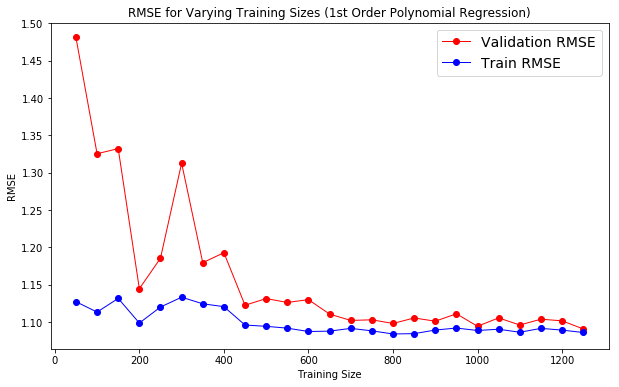

In [33]:
if (train_size>0 and train_size<1): # Define as fraction of total training samples to use
    num_in_train_set = X_train.shape[0] * train_size
if train_size>=1: # Takes into account accidental fractions larger than 1 and converts them to integers
    num_in_train_set = int(train_size)
else: # Any numbers less than zero are set to nan, which should give error so user can fix problem
    print('Invalid entry. Only positive values allowed.')
    num_in_train_set = np.nan

num_iterations = math.floor(X_train.shape[0] / num_in_train_set)

set_size_list = list( np.linspace(start = num_in_train_set, stop = num_in_train_set*num_iterations, num = num_iterations) )

# Below plots the “rmse vs. degree”
plt.figure(figsize=(10, 6))   
plt.plot(set_size_list, val_scores, "ro-", alpha=1.0, linewidth=1.0, label="Validation RMSE")
plt.plot(set_size_list, train_scores, "bo-", alpha=1.0, linewidth=1.0, label="Train RMSE")    
plt.legend(loc="best", fontsize=14) 
plt.xlabel("Training Size")
plt.ylabel("RMSE")
plt.title("RMSE for Varying Training Sizes (1st Order Polynomial Regression)")
plt.show()

From the above plot we believe it is likely best to use a training size of 1000 samples as it appears that around that point the generalization error between the training and validation sets are quite small, and the overall RMSE is relatively low as well.

We will now use a polynomial fit of order 3 and see what training size seems optimal.

We first augment the feature matrix, adding in new columns corresponding to all unique multiplicative possibilities.

In [34]:
poly_order = 3
X_train_aug=polynomialFeatures(X_train,poly_order)
print(X_train_aug.shape)

(1278, 165)


We now perform cross-validation on this 3rd order feature matrix to find the optimal hyperparameters.<br>
Note that the below box is commented out as this only has to be run once.<br>
The results have been recorded below.

In [35]:
# folds = 4 # Number of folds to use for cross validation
# epochs = 100000 # We choose to use this value
# tol = 0.0001 # We choose to use this ending condition
# error_function = mse # Error function to use for evaluation
# lambd = [1.0, 0, 0.1, 0.01, 0.001, 0.0001] # Regularization parameters to try
# learning_rate = [1.0, 0.1, 0.01, 0.001, 0.0001] # Learning rates to try
# regularizer = ['l1','l2'] # Types of regularizers to try

# model_performance_list = np.empty([1,5]) # Initialize as empty
# num_comb = len(lambd)*len(learning_rate)*len(regularizer)
# count = 1
# error_fold_train = []
# error_fold_test = []
# for lambd_curr in lambd:
#     for learning_rate_curr in learning_rate:
#         for regularizer_curr in regularizer:
#             print('Looking at combination %i of %i' %(count,num_comb))
#             count+=1
#             model_name = Linear_Regression()
#             model = [model_name.fit,model_name.predict]
#             model_args = [epochs,tol,lambd_curr,learning_rate_curr,regularizer_curr]

#             dict_temp = kFold(folds, X_train_aug, Y_train, model, model_args, error_function)
#             error_fold_train = []
#             error_fold_test = []
            
#             for kk,jj in dict_temp.items():
#                 error_fold_train.append(jj[-1][0]) # Holds error for training sets
#                 error_fold_test.append(jj[-1][1]) # Holds error for testing sets
#             eavg_train=np.mean(np.asarray(error_fold_train)) # Holds MSE for training sets
#             std_error_train = np.std(np.asarray(error_fold_train))
#             eavg_test=np.mean(np.asarray(error_fold_test)) # Holds MSE for training sets
#             std_error_test = np.std(np.asarray(error_fold_test))
#             # Below holds (lambd,learning_rate,regularizer,MSE_avg,std_dev_avg)
#             model_performance_list=np.vstack((model_performance_list,[regularizer_curr,learning_rate_curr,lambd_curr,eavg_test,eavg_train]))

# # Remove first row from model_performance_list as it contained the random values used to initialize it
# model_performance_list=np.delete(model_performance_list, [0], axis=0)

# # Save full output of s-fold cross-validation to disk for use in report
# df_s_fold = pd.DataFrame(model_performance_list,columns=['Regularization Fncn', 'Learning Rate', 'Regularization Param', 'MSE-From Testing Sets','MSE-From Training Sets']) # Convert to pandas dataframe

# print('\n')
# print(df_s_fold)

# # Replace any inf or nan with np.nan for dropping in next step
# df_s_fold=df_s_fold.replace('inf', np.nan)
# df_s_fold=df_s_fold.replace('nan', np.nan)
# # Now drop all rows containing NaN
# df_s_fold=df_s_fold.dropna()
# print('\n')
# print('Below are the values corresponding to the smallest MSE from the testing sets during cross-validation')
# # Now find row index corresponding to lowest MSE from testing sets
# print(df_s_fold[df_s_fold['MSE-From Testing Sets']==df_s_fold['MSE-From Testing Sets'].min()])

Now gather the training and validation scores for this augmented feature matrix.

From the above results it appears that the optimal parameters for a 3rd order feature matrix are as stated below:<br>
Regularization Function: l1<br>
Learning Rate: 0.01<br>
Regularization Parameter: 0.1<br>
These correspond to a test MSE: 10.1605

In [36]:
# We will thus use the following values for our 3rd order polynomial regression
epochs = 100000 # We choose to use this value
tol = 0.0001 # We choose to use this ending condition
lambd_3rd_order = 1.0 # Regularizer Parameter
learning_rate_3rd_order = 0.01
regularizer_3rd_order = 'l1'
kwargs={}

In [37]:
kwargs={}
cv = 4
train_size = 100
# Create the lists for training and validation RMSE values from the training data
train_scores,val_scores=learning_curve(model, X_train_aug, Y_train, cv, train_size, learning_rate_3rd_order, epochs, tol, regularizer_3rd_order, lambd_3rd_order, *kwargs)

Including up to bin 1 out of 12
Including up to bin 2 out of 12
Including up to bin 3 out of 12
Including up to bin 4 out of 12
Including up to bin 5 out of 12
Including up to bin 6 out of 12
Including up to bin 7 out of 12
Including up to bin 8 out of 12
Including up to bin 9 out of 12
Including up to bin 10 out of 12
Including up to bin 11 out of 12
Including up to bin 12 out of 12


Now create the learning curve for different numbers of elements incuded in the training set

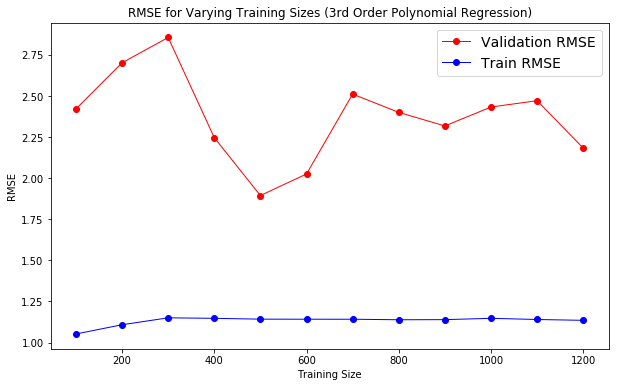

In [38]:
if (train_size>0 and train_size<1): # Define as fraction of total training samples to use
    num_in_train_set = X_train.shape[0] * train_size
if train_size>=1: # Takes into account accidental fractions larger than 1 and converts them to integers
    num_in_train_set = int(train_size)
else: # Any numbers less than zero are set to nan, which should give error so user can fix problem
    print('Invalid entry. Only positive values allowed.')
    num_in_train_set = np.nan

num_iterations = math.floor(X_train.shape[0] / num_in_train_set)

set_size_list = list( np.linspace(start = num_in_train_set, stop = num_in_train_set*num_iterations, num = num_iterations) )

# Below plots the “rmse vs. degree”
plt.figure(figsize=(10, 6))   
plt.plot(set_size_list, val_scores, "ro-", alpha=1.0, linewidth=1.0, label="Validation RMSE")
plt.plot(set_size_list, train_scores, "bo-", alpha=1.0, linewidth=1.0, label="Train RMSE")    
plt.legend(loc="best", fontsize=14) 
plt.xlabel("Training Size")
plt.ylabel("RMSE")
plt.title("RMSE for Varying Training Sizes (3rd Order Polynomial Regression)")
plt.show()

From the above plot it appears that regardless of how many elements are included in the training set the gradient descent is overfitting.<br>
I could tentatively argue that perhaps keeping around 600 samples could be optimal, but overall it doesn't look like a very good fit.

I will now plot the rmse values for the training and validation folds for polynomial fits of degree 1, 2, 3, 4, and 5.<br>
From the above results I choose to use only the first 1000 elements from my training matrix.

Before doing this I will perform cross-fold validation on the 2nd, 4th, and 5th order polynomials to find the optimal hyperparameter values.

In [41]:
poly_order = 2
X_train_aug=polynomialFeatures(X_train,poly_order)
print(X_train_aug.shape)

(1278, 45)


Now perform cross-fold validation on the second-order feature matrix<br>
Note that the below box is commented out as this only has to be run once.<br>
The results have been recorded below.

In [42]:
# folds = 4 # Number of folds to use for cross validation
# epochs = 100000 # We choose to use this value
# tol = 0.0001 # We choose to use this ending condition
# error_function = mse # Error function to use for evaluation
# lambd = [1.0, 0, 0.1, 0.01, 0.001, 0.0001] # Regularization parameters to try
# learning_rate = [1.0, 0.1, 0.01, 0.001, 0.0001] # Learning rates to try
# regularizer = ['l1','l2'] # Types of regularizers to try

# model_performance_list = np.empty([1,5]) # Initialize as empty
# num_comb = len(lambd)*len(learning_rate)*len(regularizer)
# count = 1
# error_fold_train = []
# error_fold_test = []
# for lambd_curr in lambd:
#     for learning_rate_curr in learning_rate:
#         for regularizer_curr in regularizer:
#             print('Looking at combination %i of %i' %(count,num_comb))
#             count+=1
#             model_name = Linear_Regression()
#             model = [model_name.fit,model_name.predict]
#             model_args = [epochs,tol,lambd_curr,learning_rate_curr,regularizer_curr]

#             dict_temp = kFold(folds, X_train_aug, Y_train, model, model_args, error_function)
#             error_fold_train = []
#             error_fold_test = []
            
#             for kk,jj in dict_temp.items():
#                 error_fold_train.append(jj[-1][0]) # Holds error for training sets
#                 error_fold_test.append(jj[-1][1]) # Holds error for testing sets
#             eavg_train=np.mean(np.asarray(error_fold_train)) # Holds MSE for training sets
#             std_error_train = np.std(np.asarray(error_fold_train))
#             eavg_test=np.mean(np.asarray(error_fold_test)) # Holds MSE for training sets
#             std_error_test = np.std(np.asarray(error_fold_test))
#             # Below holds (lambd,learning_rate,regularizer,MSE_avg,std_dev_avg)
#             model_performance_list=np.vstack((model_performance_list,[regularizer_curr,learning_rate_curr,lambd_curr,eavg_test,eavg_train]))

# # Remove first row from model_performance_list as it contained the random values used to initialize it
# model_performance_list=np.delete(model_performance_list, [0], axis=0)

# # Save full output of s-fold cross-validation to disk for use in report
# df_s_fold = pd.DataFrame(model_performance_list,columns=['Regularization Fncn', 'Learning Rate', 'Regularization Param', 'MSE-From Testing Sets','MSE-From Training Sets']) # Convert to pandas dataframe

# print('\n')
# print(df_s_fold)

# # Replace any inf or nan with np.nan for dropping in next step
# df_s_fold=df_s_fold.replace('inf', np.nan)
# df_s_fold=df_s_fold.replace('nan', np.nan)
# # Now drop all rows containing NaN
# df_s_fold=df_s_fold.dropna()
# print('\n')
# print('Below are the values corresponding to the smallest MSE from the testing sets during cross-validation')
# # Now find row index corresponding to lowest MSE from testing sets
# print(df_s_fold[df_s_fold['MSE-From Testing Sets']==df_s_fold['MSE-From Testing Sets'].min()])

From the above results it appears that the optimal parameters for a 2nd order feature matrix are as stated below:<br>
Regularization Function: l1<br>
Learning Rate: 0.1<br>
Regularization Parameter: 1.0<br>
These correspond to a test MSE of 1.0013

In [43]:
# We will thus use the following values for our 2nd order polynomial regression
epochs = 100000 # We choose to use this value
tol = 0.0001 # We choose to use this ending condition
lambd_2nd_order = 1.0 # Regularizer Parameter
learning_rate_2nd_order = 0.1
regularizer_2nd_order = 'l1'
kwargs={}

In [44]:
poly_order = 4
X_train_aug=polynomialFeatures(X_train,poly_order)
print(X_train_aug.shape)

(1278, 495)


Now perform cross-fold validation on the fourth-order feature matrix<br>
Note that the below box is commented out as this only has to be run once.<br>
The results have been recorded below.

In [45]:
# folds = 4 # Number of folds to use for cross validation
# epochs = 100000 # We choose to use this value
# tol = 0.0001 # We choose to use this ending condition
# error_function = mse # Error function to use for evaluation
# lambd = [1.0, 0, 0.1, 0.01, 0.001, 0.0001] # Regularization parameters to try
# learning_rate = [1.0, 0.1, 0.01, 0.001, 0.0001] # Learning rates to try
# regularizer = ['l1','l2'] # Types of regularizers to try

# model_performance_list = np.empty([1,5]) # Initialize as empty
# num_comb = len(lambd)*len(learning_rate)*len(regularizer)
# count = 1
# error_fold_train = []
# error_fold_test = []
# for lambd_curr in lambd:
#     for learning_rate_curr in learning_rate:
#         for regularizer_curr in regularizer:
#             print('Looking at combination %i of %i' %(count,num_comb))
#             count+=1
#             model_name = Linear_Regression()
#             model = [model_name.fit,model_name.predict]
#             model_args = [epochs,tol,lambd_curr,learning_rate_curr,regularizer_curr]

#             dict_temp = kFold(folds, X_train_aug, Y_train, model, model_args, error_function)
#             error_fold_train = []
#             error_fold_test = []
            
#             for kk,jj in dict_temp.items():
#                 error_fold_train.append(jj[-1][0]) # Holds error for training sets
#                 error_fold_test.append(jj[-1][1]) # Holds error for testing sets
#             eavg_train=np.mean(np.asarray(error_fold_train)) # Holds MSE for training sets
#             std_error_train = np.std(np.asarray(error_fold_train))
#             eavg_test=np.mean(np.asarray(error_fold_test)) # Holds MSE for training sets
#             std_error_test = np.std(np.asarray(error_fold_test))
#             # Below holds (lambd,learning_rate,regularizer,MSE_avg,std_dev_avg)
#             model_performance_list=np.vstack((model_performance_list,[regularizer_curr,learning_rate_curr,lambd_curr,eavg_test,eavg_train]))

# # Remove first row from model_performance_list as it contained the random values used to initialize it
# model_performance_list=np.delete(model_performance_list, [0], axis=0)

# # Save full output of s-fold cross-validation to disk for use in report
# df_s_fold = pd.DataFrame(model_performance_list,columns=['Regularization Fncn', 'Learning Rate', 'Regularization Param', 'MSE-From Testing Sets','MSE-From Training Sets']) # Convert to pandas dataframe

# print('\n')
# print(df_s_fold)

# # Replace any inf or nan with np.nan for dropping in next step
# df_s_fold=df_s_fold.replace('inf', np.nan)
# df_s_fold=df_s_fold.replace('nan', np.nan)
# # Now drop all rows containing NaN
# df_s_fold=df_s_fold.dropna()
# print('\n')
# print('Below are the values corresponding to the smallest MSE from the testing sets during cross-validation')
# # Now find row index corresponding to lowest MSE from testing sets
# print(df_s_fold[df_s_fold['MSE-From Testing Sets']==df_s_fold['MSE-From Testing Sets'].min()])

From the above results it appears that the optimal parameters for a 4th order feature matrix are as stated below:<br>
Regularization Function: l1<br>
Learning Rate: 0.0001<br>
Regularization Parameter: 1.0<br>
These correspond to a test MSE: 153.4894

In [46]:
# We will thus use the following values for our 4th order polynomial regression
epochs = 100000 # We choose to use this value
tol = 0.0001 # We choose to use this ending condition
lambd_4th_order = 1.0 # Regularizer Parameter
learning_rate_4th_order = 0.0001
regularizer_4th_order = 'l1'
kwargs={}

In [47]:
poly_order = 5
X_train_aug=polynomialFeatures(X_train,poly_order)
print(X_train_aug.shape)

(1278, 1287)


Now perform cross-fold validation on the fifth-order feature matrix<br>
Note that the below box is commented out as this only has to be run once.<br>
The results have been recorded below.

In [48]:
# folds = 4 # Number of folds to use for cross validation
# epochs = 100000 # We choose to use this value
# tol = 0.0001 # We choose to use this ending condition
# error_function = mse # Error function to use for evaluation
# lambd = [1.0, 0, 0.1, 0.01, 0.001, 0.0001] # Regularization parameters to try
# learning_rate = [1.0, 0.1, 0.01, 0.001, 0.0001] # Learning rates to try
# regularizer = ['l1','l2'] # Types of regularizers to try

# model_performance_list = np.empty([1,5]) # Initialize as empty
# num_comb = len(lambd)*len(learning_rate)*len(regularizer)
# count = 1
# error_fold_train = []
# error_fold_test = []
# for lambd_curr in lambd:
#     for learning_rate_curr in learning_rate:
#         for regularizer_curr in regularizer:
#             print('Looking at combination %i of %i' %(count,num_comb))
#             count+=1
#             model_name = Linear_Regression()
#             model = [model_name.fit,model_name.predict]
#             model_args = [epochs,tol,lambd_curr,learning_rate_curr,regularizer_curr]

#             dict_temp = kFold(folds, X_train_aug, Y_train, model, model_args, error_function)
#             error_fold_train = []
#             error_fold_test = []
            
#             for kk,jj in dict_temp.items():
#                 error_fold_train.append(jj[-1][0]) # Holds error for training sets
#                 error_fold_test.append(jj[-1][1]) # Holds error for testing sets
#             eavg_train=np.mean(np.asarray(error_fold_train)) # Holds MSE for training sets
#             std_error_train = np.std(np.asarray(error_fold_train))
#             eavg_test=np.mean(np.asarray(error_fold_test)) # Holds MSE for training sets
#             std_error_test = np.std(np.asarray(error_fold_test))
#             # Below holds (lambd,learning_rate,regularizer,MSE_avg,std_dev_avg)
#             model_performance_list=np.vstack((model_performance_list,[regularizer_curr,learning_rate_curr,lambd_curr,eavg_test,eavg_train]))

# # Remove first row from model_performance_list as it contained the random values used to initialize it
# model_performance_list=np.delete(model_performance_list, [0], axis=0)

# # Save full output of s-fold cross-validation to disk for use in report
# df_s_fold = pd.DataFrame(model_performance_list,columns=['Regularization Fncn', 'Learning Rate', 'Regularization Param', 'MSE-From Testing Sets','MSE-From Training Sets']) # Convert to pandas dataframe

# print('\n')
# print(df_s_fold)

# # Replace any inf or nan with np.nan for dropping in next step
# df_s_fold=df_s_fold.replace('inf', np.nan)
# df_s_fold=df_s_fold.replace('nan', np.nan)
# # Now drop all rows containing NaN
# df_s_fold=df_s_fold.dropna()
# print('\n')
# print('Below are the values corresponding to the smallest MSE from the testing sets during cross-validation')
# # Now find row index corresponding to lowest MSE from testing sets
# print(df_s_fold[df_s_fold['MSE-From Testing Sets']==df_s_fold['MSE-From Testing Sets'].min()])

From the above results it appears that the optimal parameters for a 5th order feature matrix are as stated below:<br>
Regularization Function: l1<br>
Learning Rate: 0.0001<br>
Regularization Parameter: 1.0<br>
These correspond to a test MSE: 832.3524

In [49]:
# We will thus use the following values for our 5th order polynomial regression
epochs = 100000 # We choose to use this value
tol = 0.0001 # We choose to use this ending condition
lambd_5th_order = 1.0 # Regularizer Parameter
learning_rate_5th_order = 0.0001
regularizer_5th_order = 'l1'
kwargs={}

Now we create the Learning Curve for different orders of polynomial regression<br>
Each of the optimal hyperparameters has been defined as a global parameter such that it can be used in the calculation for each order of polynomial.<br>
If an order is requested for which we have not defined a global variable it will default to using the provided default values, which here we will use as being the optimal hyperparameters for a linear fit.

Generating output for Polynomial Order 1 out of 5
Generating output for Polynomial Order 2 out of 5
Generating output for Polynomial Order 3 out of 5
Generating output for Polynomial Order 4 out of 5
Generating output for Polynomial Order 5 out of 5


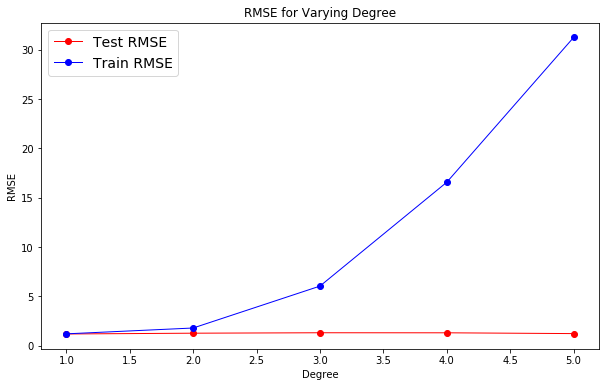

In [50]:
kwargs={}
num_in_training_set = 1000
cv = 4
maxPolynomialDegree = 5

# Include the optimal number of elements in the training matrix
curr_rows = list(range(0,num_in_training_set))
X_train_sub = X_train[curr_rows,:] # Grab selected row range in X_train
Y_train_sub = Y_train[curr_rows,:] # Grab selected row range in Y_train

model_name = Linear_Regression()
model = [model_name.fit,model_name.predict]
model_args = [epochs,tol,lambd_curr,learning_rate_curr,regularizer_curr]

plot_polynomial_model_complexity(model,X_train_sub,Y_train_sub,cv,maxPolynomialDegree,learning_rate_1st_order, epochs, tol, regularizer_1st_order, lambd_1st_order, *kwargs)

From here it appears that perhaps a 2nd degree polynomial is acceptable, but certainly anything more is underfitting.<br>

This result makes me believe that a linear model is going to be a better predictor than a 2nd order polynomial.

We will now implement Stochastic Gradient Descent.

Below we employ k-fold cross validation to identify the optimal parameters.<br>
Note that we have chosen to employ a larger epoch and tolerance as the more random oscillations employed with stochastic gradient descent, as compared with batch gradient descent, mean it will both take longer to reach the optimal values and also it is possible for two randomly chosen rows to have very similar gradients.

Note that the below box is commented out as this only has to be run once.<br>
The results have been recorded below.

In [51]:
# folds = 4 # Number of folds to use for cross validation
# epochs = 100000 # We choose to use this value
# tol = 0.0001 # We choose to use this ending condition
# error_function = mse # Error function to use for evaluation
# lambd = [1.0, 0, 0.1, 0.01, 0.001, 0.0001] # Regularization parameters to try
# learning_rate = [3.0, 2.0, 1.0, 0.1, 0.01, 0.001, 0.001] # Learning rates to try
# regularizer = ['l1','l2'] # Types of regularizers to try

# model_performance_list = np.empty([1,5]) # Initialize as empty
# num_comb = len(lambd)*len(learning_rate)*len(regularizer)
# count = 1
# error_fold_train = []
# error_fold_test = []
# for lambd_curr in lambd:
#     for learning_rate_curr in learning_rate:
#         for regularizer_curr in regularizer:
#             print('Looking at combination %i of %i' %(count,num_comb))
#             count+=1
#             model_name = Linear_Regression()
#             model = [model_name.fit_stochastic,model_name.predict]
#             model_args = [epochs,tol,lambd_curr,learning_rate_curr,regularizer_curr]

#             dict_temp = kFold(folds, X, Y, model, model_args, error_function)
#             error_fold_train = []
#             error_fold_test = []
            
#             for kk,jj in dict_temp.items():
#                 error_fold_train.append(jj[-1][0]) # Holds error for training sets
#                 error_fold_test.append(jj[-1][1]) # Holds error for testing sets
#             eavg_train=np.mean(np.asarray(error_fold_train)) # Holds MSE for training sets
#             std_error_train = np.std(np.asarray(error_fold_train))
#             eavg_test=np.mean(np.asarray(error_fold_test)) # Holds MSE for training sets
#             std_error_test = np.std(np.asarray(error_fold_test))
#             # Below holds (lambd,learning_rate,regularizer,MSE_avg,std_dev_avg)
#             model_performance_list=np.vstack((model_performance_list,[regularizer_curr,learning_rate_curr,lambd_curr,eavg_test,eavg_train]))

# # Remove first row from model_performance_list as it contained the random values used to initialize it
# model_performance_list=np.delete(model_performance_list, [0], axis=0)

# # Save full output of s-fold cross-validation to disk for use in report
# df_s_fold = pd.DataFrame(model_performance_list,columns=['Regularization Fncn', 'Learning Rate', 'Regularization Param', 'MSE-From Testing Sets','MSE-From Training Sets']) # Convert to pandas dataframe

# print('\n')
# print(df_s_fold)

# # Replace any inf or nan with np.nan for dropping in next step
# df_s_fold=df_s_fold.replace('inf', np.nan)
# df_s_fold=df_s_fold.replace('nan', np.nan)
# # Now drop all rows containing NaN
# df_s_fold=df_s_fold.dropna()
# print('\n')
# print('Below are the values corresponding to the smallest MSE from the testing sets during cross-validation')
# # Now find row index corresponding to lowest MSE from testing sets
# print(df_s_fold[df_s_fold['MSE-From Testing Sets']==df_s_fold['MSE-From Testing Sets'].min()])

From the above results it appears that the optimal parameters are as stated below:<br>
Regularization Function: l1<br>
Learning Rate: 3.0<br>
Regularization Parameter: 0.1<br>
As there are no nan or inf included in the output it appears that using a learning rate of 1.0 is acceptable for stochastic gradient descent.

We will thus use the following parameters for the following predictions using Stochastic Gradient Descent

In [52]:
epochs = 1000000 # We choose to use this value
tol = 0.00001 # We choose to use this ending condition
lambd = 0.01 # Regularizer Parameter
learning_rate = 3.0
regularizer = 'l2'

We now use these parameters to find the optimal weights, using our training data for this calculation. This is done below.

In [53]:
class_lin_reg = Linear_Regression() # Initialize class
# Below we perform fit to the testing data, which keeps the determined optimal theta inside the class
class_lin_reg.fit_stochastic( X_train, Y_train, epochs,tol,lambd,learning_rate,regularizer, **kwargs)

Before we test these weights against our test data let's see how they do with the training set. This is shown below.

In [54]:
Y_train_pred=class_lin_reg.predict(X_train)
print('The mean squared error for this prediction from the training set is: %0.2f' %mse(Y_train, Y_train_pred))

The mean squared error for this prediction from the training set is: 0.77


Now that we have the optimal weights, which are stored in the class instance class_lin_reg, we will apply this to our test data. This is done below.

In [55]:
Y_test_pred=class_lin_reg.predict(X_test)
print('The mean squared error for this prediction for the testing set is: %0.2f' %mse(Y_test, Y_test_pred))

The mean squared error for this prediction for the testing set is: 0.70
